In [1]:
import os
import re
import json
import argparse
from typing import List, Dict, Any

import pandas as pd
import matplotlib.pyplot as plt

# Var

In [2]:
home = "/home/filipe/Workspace/dynff/results/motivational/exp-4/v1-random-layer-recombination/simplecnn/"
PATTERN = re.compile(
    r"^fedavg_random_(?P<strategy>constant|recombination)_10_battery_False_dataset_cifar10_dir_(?P<alpha>0\.1|0\.3|1\.0)_seed_(?P<seed>\d+)$"
)

# Aux 

In [9]:
def collect_rows(root: str) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    if not os.path.isdir(root):
        raise FileNotFoundError(f"Root directory not found: {root}")
    for name in sorted(os.listdir(root)):
        full = os.path.join(root, name)
        if not os.path.isdir(full):
            continue
        m = PATTERN.match(name)
        if not m:
            # Skip directories that don't match the expected pattern
            continue
        strategy = m.group("strategy")
        alpha = float(m.group("alpha"))
        seed = int(m.group("seed"))
        json_path = os.path.join(full, "model_performance.json")
        if not os.path.isfile(json_path):
            print(f"[warn] Missing model_performance.json in {full}")
            continue
        try:
            with open(json_path, "r", encoding="utf-8") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[warn] Failed to read {json_path}: {e}")
            continue

        # data: {"0": {"cen_loss": ..., "cen_accuracy": ...}, ...}
        for r_str, metrics in data.items():
            try:
                r = int(r_str)
                acc = float(metrics.get("cen_accuracy"))
            except Exception:
                continue
            rows.append(
                {
                    "strategy": strategy,
                    "alpha": alpha,
                    "seed": seed,
                    "round": r,
                    "accuracy": acc,
                }
            )
    return rows


def make_dataframe(rows: List[Dict[str, Any]]) -> pd.DataFrame:
    if not rows:
        raise RuntimeError("No data rows collected. Check your root path/patterns.")
    df = pd.DataFrame(rows)
    # Ensure proper dtypes
    df["alpha"] = df["alpha"].astype(float)
    df["seed"] = df["seed"].astype(int)
    df["round"] = df["round"].astype(int)
    df["accuracy"] = df["accuracy"].astype(float)
    df["strategy"] = df["strategy"].astype("category")
    return df.sort_values(["alpha", "strategy", "seed", "round"]).reset_index(drop=True)


def plot_grid(df: pd.DataFrame):
    # Mean across seeds for each (alpha, strategy, round)
    mean_df = (
        df.groupby(["alpha", "strategy", "round"], as_index=False)["accuracy"]
        .mean()
        .rename(columns={"accuracy": "mean_accuracy"})
    )

    alphas = sorted(mean_df["alpha"].unique())
    n = len(alphas)
    if n == 0:
        raise RuntimeError("No alphas found in data.")

    # Build grid: one subplot per alpha
    # Use a single row if <= 3 alphas; otherwise compute rows/cols
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4.5 * rows), sharey=True)
    if isinstance(axes, plt.Axes):
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]

    # Determine rounds range (for consistent x-limits)
    rmin = int(mean_df["round"].min())
    rmax = int(mean_df["round"].max())

    strategies = list(mean_df["strategy"].cat.categories) if hasattr(mean_df["strategy"], "cat") else sorted(mean_df["strategy"].unique())

    for idx, alpha in enumerate(alphas):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]
        sub = mean_df[mean_df["alpha"] == alpha]
        for s in strategies:
            line_df = sub[sub["strategy"] == s].sort_values("round")
            if line_df.empty:
                continue
            ax.plot(line_df["round"], line_df["mean_accuracy"], label=str(s))
        ax.set_title(f"α = {alpha}")
        ax.set_xlim(rmin, rmax)
        ax.set_xlabel("Rodada")
        if c == 0:
            ax.set_ylabel("Acurácia (média dos seeds)")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(title="Estratégia")

    # Remove any unused subplots
    for k in range(n, rows * cols):
        r = k // cols
        c = k % cols
        fig.delaxes(axes[r][c])

    fig.suptitle("CIFAR-10 • Acurácia central vs. Rodada (média por estratégia)", y=0.995)
    fig.tight_layout()
    
    plt.show()

# Process

In [7]:
rows = collect_rows(home)

In [8]:
df = make_dataframe(rows)

# Graphics

/tmp/ipykernel_355285/515350197.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["alpha", "strategy", "round"], as_index=False)["accuracy"]


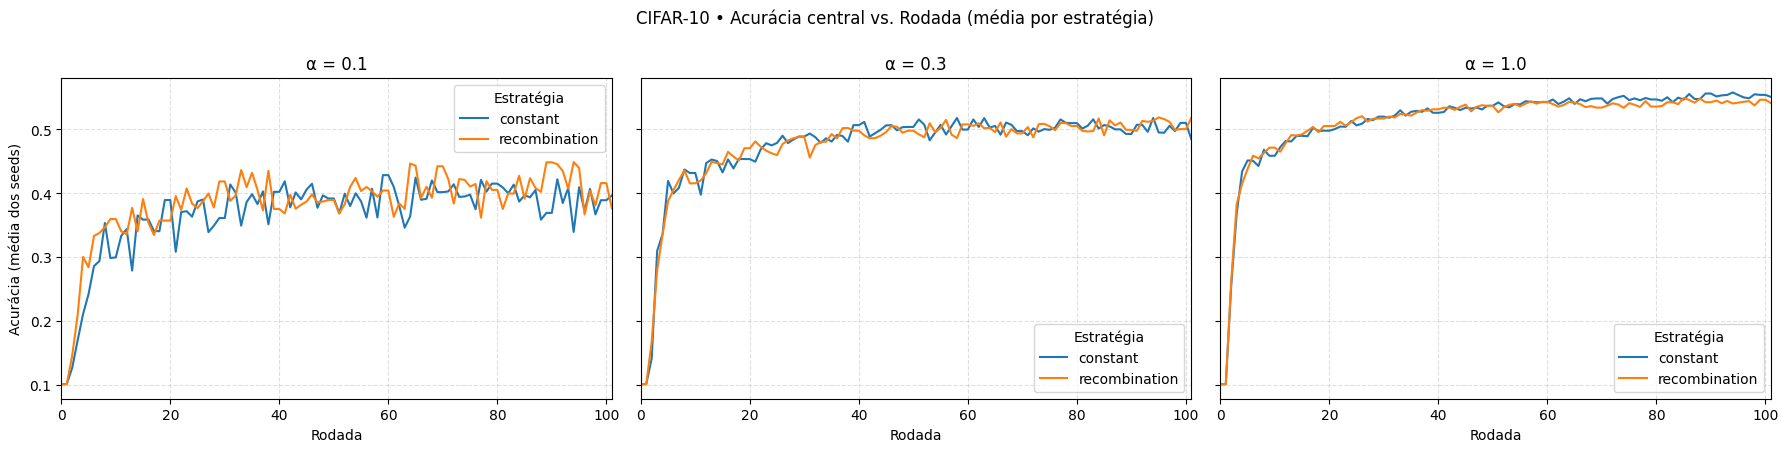

In [10]:
plot_grid(df)